# Solutions Assignment 8

## Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.transforms.functional import crop
from torch.utils.data import Dataset
import cv2
import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from collections import defaultdict
from tbparse import SummaryReader
import torchgadgets as tg
tg.set_random_seed(42)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from pathlib import Path as P


from run import Trainer, Market1501

/home/user/denninge/anaconda3/envs/vision_lab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utility Functions

In [51]:
plt.style.use('seaborn-v0_8')

def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def save_model(model, optimizer, epoch, stats, margin, pretrained=False):
    """ Saving model checkpoint """
    
    if(not os.path.exists("checkpoints")):
        os.makedirs("checkpoints")
    savepath = f"checkpoints/checkpoint_epoch_{epoch}_margin_{margin}_pretrained_{str(pretrained)}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath, map_location="cpu")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

def visualize_progress(trainer, train_loss, val_loss):
    """ Visualizing loss and accuracy """
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    x_ticks_pos = np.arange(0, trainer.config['num_iterations']*(trainer.config['num_epochs']+1), trainer.config['num_iterations'])
    x_ticks = np.arange(0,trainer.config['num_epochs']+1)

    smooth_train = smooth(train_loss, 31)
    ax[0].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_train, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xticks(x_ticks_pos, x_ticks)
    ax[0].set_xlabel("# Epoch")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_yscale("linear")
    ax[0].set_title("Training Progress (linear)")
    
    ax[1].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[1].plot(smooth_train, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[1].legend(loc="best")
    ax[1].set_xticks(x_ticks_pos, x_ticks)
    ax[1].set_xlabel("# Epoch")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_yscale("log")
    ax[1].set_title("Training Progress (log)")

    N_ITERS = len(val_loss)
    ax[2].plot(x_ticks_pos, val_loss, c="red", label="Loss", linewidth=3, alpha=0.5)
    ax[2].legend(loc="best")
    ax[2].set_xticks(x_ticks_pos, x_ticks)
    ax[2].set_xlabel("# Epoch")
    ax[2].set_ylabel("CE Loss")
    ax[2].set_title(f"Valid Progress")

    return

def display_projections(points, labels, ax=None, legend=None, limit_labels=15, images=None):
    """ Displaying low-dimensional data projections """

    COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
              'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]

    unique_labels = list(np.unique(labels)[:limit_labels])
    legend = [f"Class {l}" for l in unique_labels] if legend is None else legend
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(36, 24))

    for i, l in enumerate(unique_labels):
        idx = np.where(l == labels)
        ax.scatter(points[idx, 0], points[idx, 1], label=legend[i], c=COLORS[i % len(COLORS)])

    if images is not None:
        for i, point in enumerate(points):
            xy = [point[0], point[1]]
            arr_img = images[i]
            # Convert arr_img to grayscale
            arr_img = ToPILImage()(arr_img)
            l = labels[i]
            if l in unique_labels:
                imagebox = OffsetImage(arr_img, zoom=1)
                imagebox.image.axes = ax
                ab = AnnotationBbox(imagebox, xy,
                                    xybox=(0, 0),
                                    xycoords='data',
                                    boxcoords="offset points",
                                    pad=0.1,
                                    bboxprops=dict(edgecolor=COLORS[unique_labels.index(l)], lw=2)
                                    )
                ax.add_artist(ab)

    # Move the legend outside the figure
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


def load_tensorboard_logs(exp_name, run_name):
    log_dir = P(os.getcwd(), 'experiments', exp_name, run_name, 'logs')
    reader = SummaryReader(log_dir, pivot=True)
    train_data = reader.scalars
    train_loss = train_data.loc[:,'iteration_metrics/train/loss'].to_numpy().astype(float)
    test_loss = train_data.loc[:,'epoch_metrics/test/loss'].to_numpy().astype(float)
    train_loss = train_loss[~np.isnan(train_loss)]
    test_loss = test_loss[~np.isnan(test_loss)]
    return train_loss, test_loss

def visualize_dataset(meta_dir, is_train=True, layout=(4,4)):
    NUM_IMG = layout[0]*layout[1]
    num_img_pp = layout[0]
    num_persons = layout[1]

    dataset_path = "data/Market-1501/bounding_box_train" if is_train else "data/Market-1501/bounding_box_test"
    person_ids = list(meta_dir.keys())
    np.random.shuffle(person_ids)

    fig, ax = plt.subplots(layout[0], layout[1])
    fig.set_size_inches(3 * layout[1], 3 * layout[0])

    offset = 0

    for x in range(num_persons):
        label = person_ids[x+offset]
        img_paths = list(meta_dir[label].values())
        while len(img_paths) < NUM_IMG:
            offset += 1
            label = person_ids[x+offset]
            img_paths = list(meta_dir[label].values())
        np.random.shuffle(img_paths)
        for y in range(num_img_pp):
            img_path = os.path.join(dataset_path, img_paths[y])
            img = Image.open(img_path)
            ax[y][x].imshow(img)
            ax[y][x].axis('off')
            ax[y][x].set_title(f"Label: {label}", fontsize=10)
            
def get_images_from_dataset(meta_dir, n_labels: int, is_train=True, labels: list = None, min_imgs: int = None):
    """
        Function to load images from one class for evaluation
    """
    dataset = Market1501(is_train=is_train, transforms=tv.transforms.ToTensor())
    if labels is None:
        labels = list(meta_dir.keys())
        np.random.shuffle(labels)
    
    offset = 0
    class_imgs = []
    classes_list = []

    for n in range(n_labels):
        label = labels[n+offset]
        img_ids = list(meta_dir[label].keys())
        imgs = []
        classes = []
        while min_imgs is not None and len(img_ids) < min_imgs:
            offset += 1
            label = labels[n+offset]
            img_ids = list(meta_dir[label].keys())
        for id in img_ids:
            img, _ = dataset[int(id)]
            imgs.append(img)
            classes.append(int(label))
        imgs = torch.stack(imgs)
        classes = torch.Tensor(classes).to(dtype=int)
        class_imgs.append(imgs)
        classes_list.append(classes)
        

    return class_imgs, classes_list
            
   
def compute_model_embedding(trainer, images):

    embedding_vectors = []
    for img_tensor in images:
        class_embedding = trainer.get_embedding_vector(img_tensor)
        embedding_vectors.append(class_embedding)

    return embedding_vectors

def cluster_evaluation(inputs, labels, images=None):
    pca_imgs = PCA(n_components=2).fit_transform(inputs)
    tsne_imgs = TSNE(n_components=2).fit_transform(inputs)

    plt.style.use('seaborn-v0_8')
    fig,ax = plt.subplots(1,2,figsize=(26,8))
    display_projections(pca_imgs, labels, ax=ax[0], legend=None, limit_labels=16, images=images)
    ax[0].set_title("PCA Projection")
    display_projections(tsne_imgs, labels, ax=ax[1], legend=None, limit_labels=16, images=images)
    ax[1].set_title("T-SNE Projection")
    


## Dataset

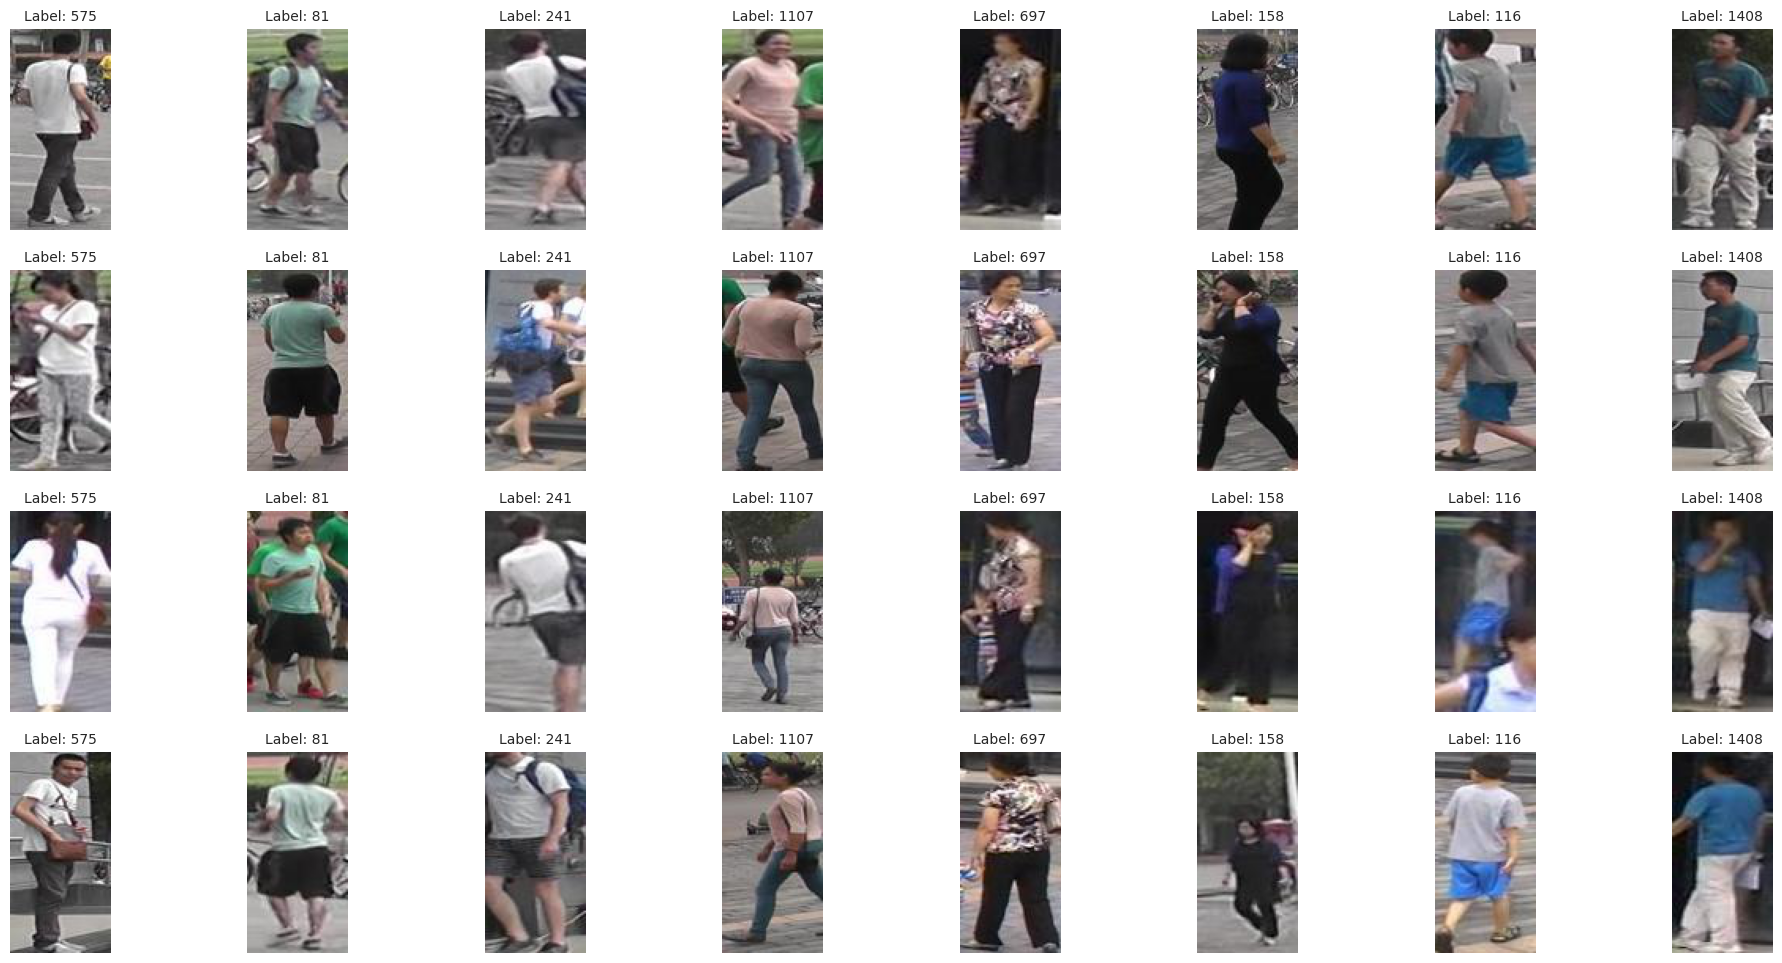

In [3]:
with open('data/Market-1501/train_meta_dir.json', 'r') as f:
    train_set_meta_dir = json.load(f)

with open('data/Market-1501/test_meta_dir.json', 'r') as f:
    test_set_meta_dir = json.load(f)

visualize_dataset(train_set_meta_dir, layout=(4,8))

Text(0.5, 1.0, 'T-SNE Proj. of Images')

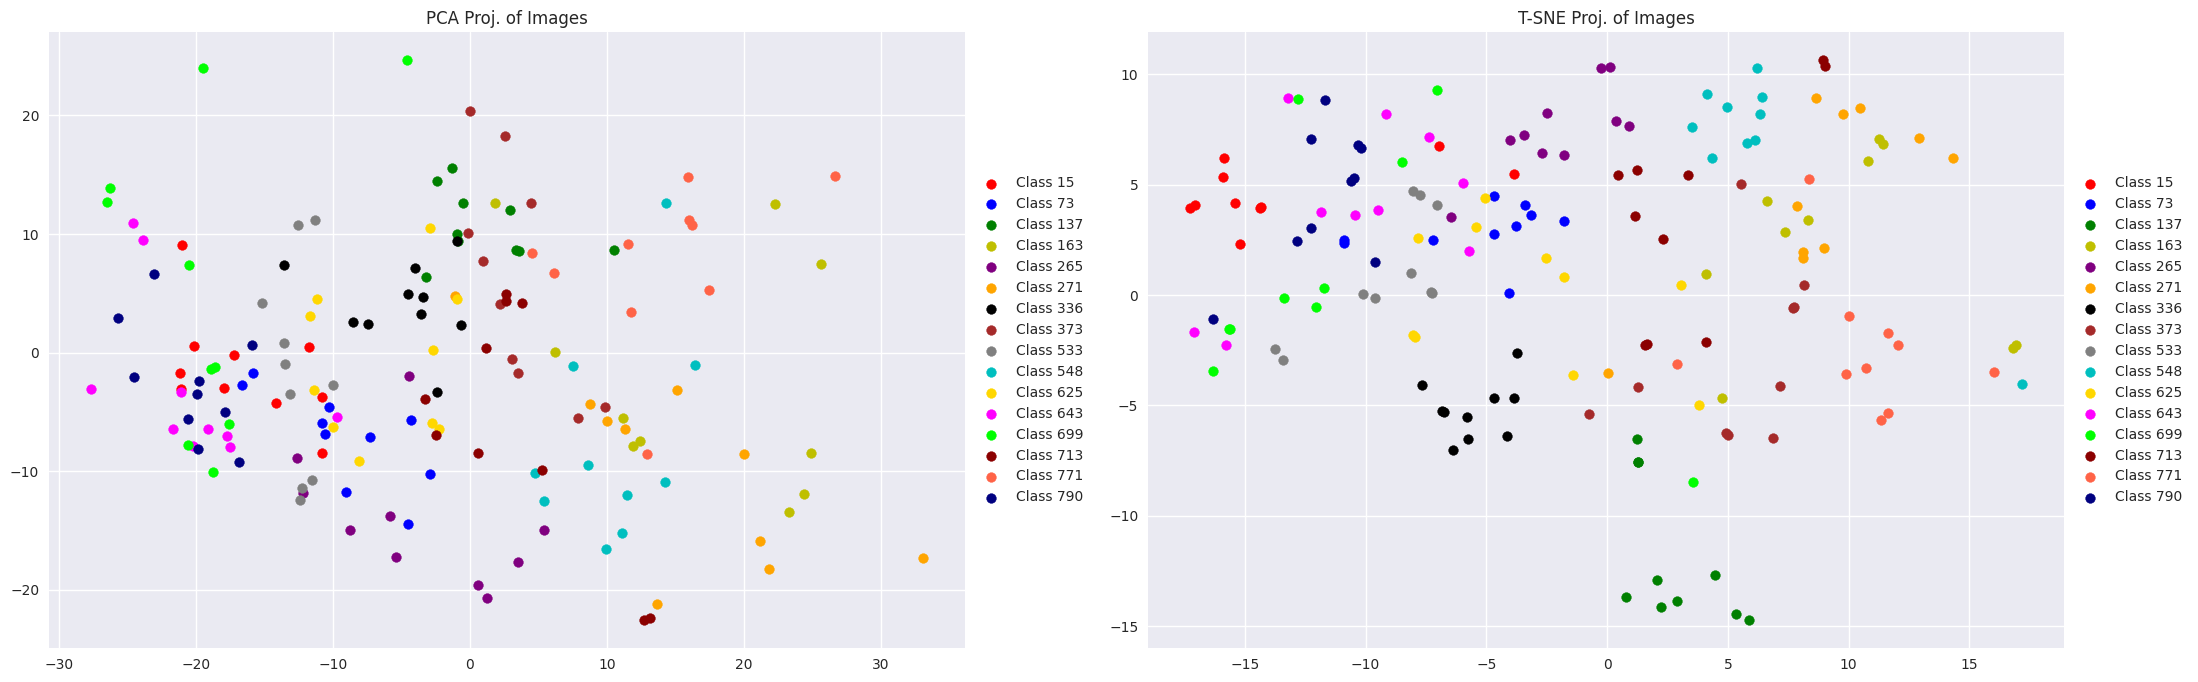

In [4]:

###--- Sampling of images for Evaluation ---###
NUM_CLASSES = 16
NUM_IMGS_PER_CLASS = 15

eval_imgs, eval_labels = get_images_from_dataset(test_set_meta_dir, NUM_CLASSES, is_train=False, min_imgs=NUM_IMGS_PER_CLASS)
eval_imgs = [img[:NUM_IMGS_PER_CLASS] for img in eval_imgs]
eval_labels = [lbl[:NUM_IMGS_PER_CLASS] for lbl in eval_labels]

lbls_flatten = np.concatenate([lbl.numpy() for lbl in eval_labels], axis=0).flatten()

imgs_flatten = [torch.flatten(img, start_dim=1, end_dim=-1).numpy() for img in eval_imgs]
imgs_flatten = np.concatenate(imgs_flatten, axis=0)

# Generate pca embeddings for model without pretraining
pca_class_imgs = []

cluster_evaluation(imgs_flatten, lbls_flatten)

## ResNet-18 Pre-trained

In [5]:
exp_name = "resnet18_pretrained"
run_name = "run_1"
epoch = 20

In [6]:
pre_trained_trainer = Trainer(exp_name, run_name)
pre_trained_trainer.load_checkpoint(epoch)

Model checkpoint was load from: /home/user/denninge/VisionLabSS23/Assignments_8/experiments/resnet18_pretrained/run_1/checkpoints/checkpoint_20.pth


In [19]:
pre_trained_train_loss, pre_trained_test_loss = load_tensorboard_logs(exp_name, run_name)

### Training Progress

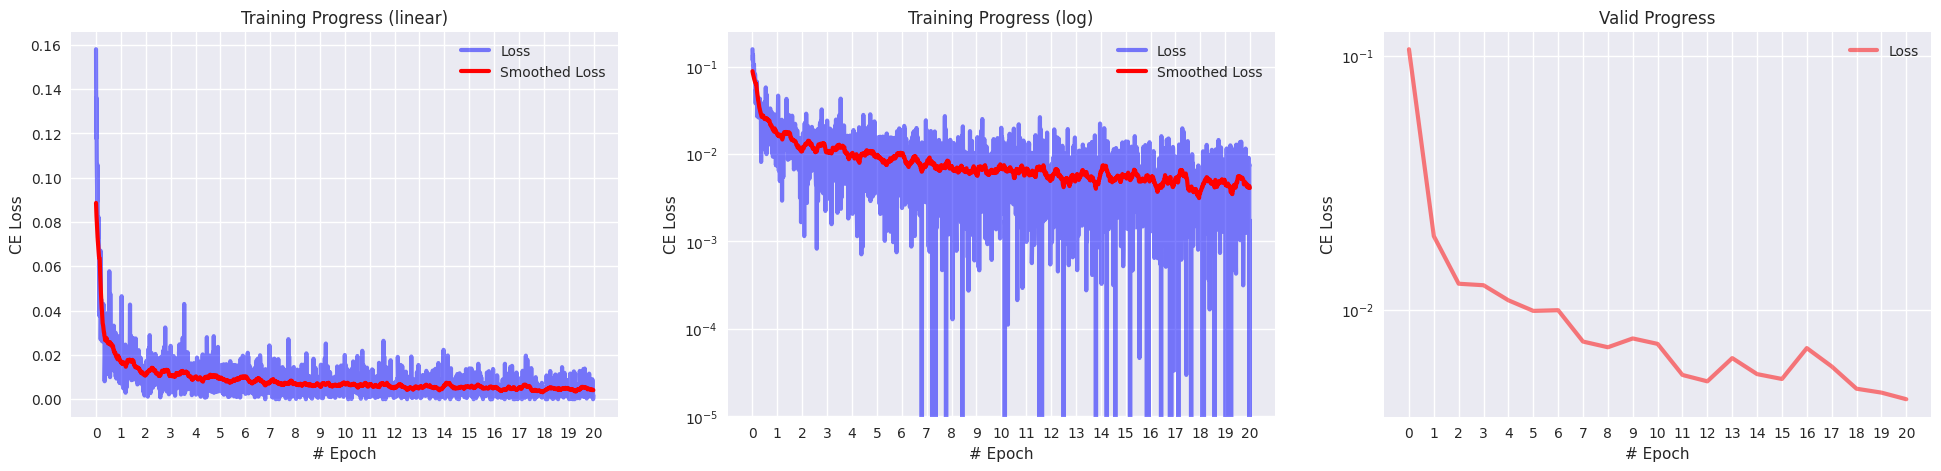

In [26]:
visualize_progress(pre_trained_trainer, pre_trained_train_loss, pre_trained_test_loss)

### Embedding Visualization

In [ ]:
model_emb = compute_model_embedding(pre_trained_trainer, eval_imgs)
model_emb = torch.flatten(torch.stack(model_emb, dim=0), start_dim=0, end_dim=1).numpy()

cluster_evaluation(model_emb, lbls_flatten)


## ResNet-18 "From Scratch"

In [27]:
exp_name = "resnet18_scratch"
run_name = "run_1"
epoch = 20

In [28]:
scratch_trainer = Trainer(exp_name, run_name)
scratch_trainer.load_checkpoint(epoch)

Model checkpoint was load from: /home/user/denninge/VisionLabSS23/Assignments_8/experiments/resnet18_scratch/run_1/checkpoints/checkpoint_20.pth


In [31]:
scratch_train_loss, scratch_test_loss = load_tensorboard_logs(exp_name, run_name)

### Training Progress

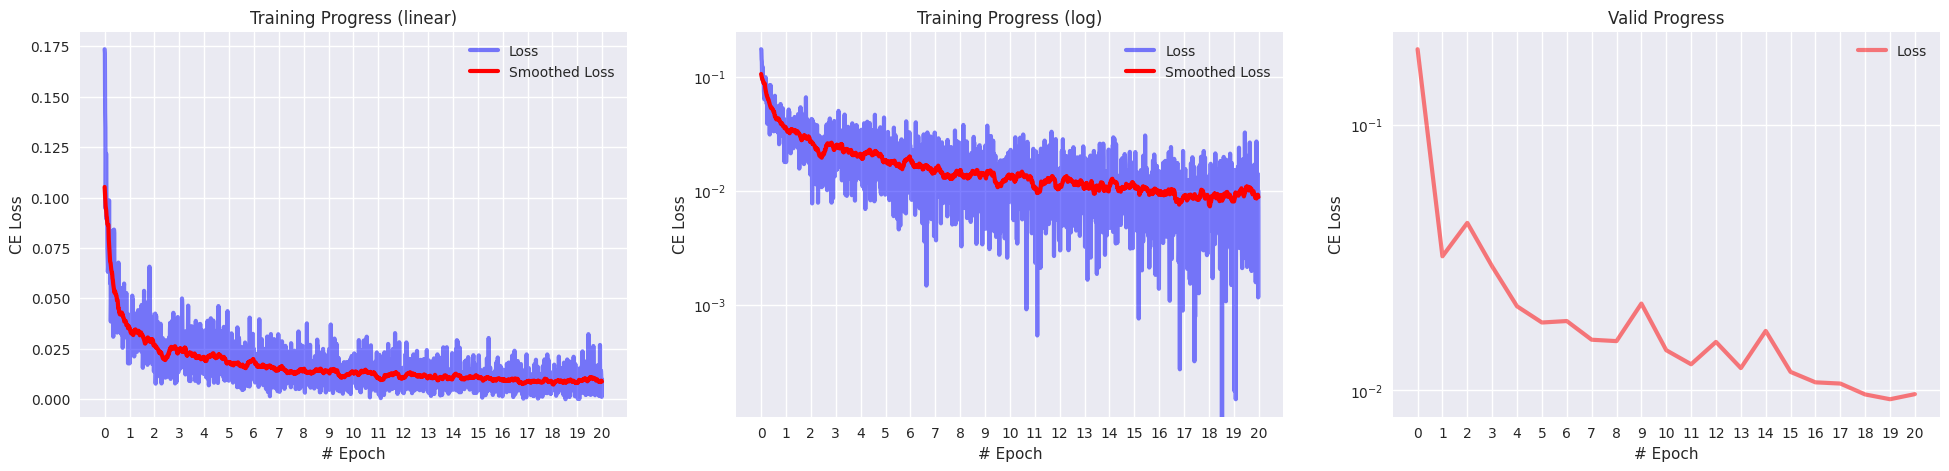

In [32]:
visualize_progress(scratch_trainer, scratch_train_loss, scratch_test_loss)


### Embedding Visualization

## ResNet-18 with Semi-hard Negative Mining

In [ ]:
exp_name = "resnet18_mining"
run_name = "run_1"
epoch = 20

## ResNet-18 with Angular Loss

## ResNet-18 with N-Pair Loss